In [1]:
import pandas as pd
import numpy as np
from typing import Union
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,recall_score,f1_score,precision_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import math
import string
import spacy
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/content/FinalBalancedDataset.csv")
len(df)

56745

In [3]:
def drop(DataFrame : object, columns : Union[str,list]):
    try:
        DataFrame.drop(columns,axis=1,inplace=True)
        print(f'Succefully Dropped "{columns}" columns')
    except Exception as e:
        print(e)

In [4]:
drop(df,'Unnamed: 0')

Succefully Dropped "Unnamed: 0" columns


In [5]:
df

,Toxicity,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
...,...,...
56740,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
56741,1,"you've gone and broke the wrong heart baby, an..."
56742,1,young buck wanna eat!!.. dat nigguh like I ain...
56743,1,youu got wild bitches tellin you lies


In [6]:
#Removing punctuations and digits from the string
def remove_punc_dig(text : str):
    '''
    text : str
    This function will remove all the punctuations and digits from the "text"
    '''
    to_remove = string.punctuation + string.digits
    cur_text = ""
    for i in range(len(text)):
        if text[i] in to_remove:
            cur_text += " "
        else:
            cur_text += text[i].lower()
    cur_text = " ".join(cur_text.split())
    return cur_text

In [7]:
df['cur_tweet'] = df['tweet'].apply(lambda x:remove_punc_dig(x))

In [8]:
df

,Toxicity,tweet,cur_tweet
0,0,@user when a father is dysfunctional and is s...,user when a father is dysfunctional and is so ...
1,0,@user @user thanks for #lyft credit i can't us...,user user thanks for lyft credit i can t use c...
2,0,bihday your majesty,bihday your majesty
3,0,#model i love u take with u all the time in ...,model i love u take with u all the time in urð...
4,0,factsguide: society now #motivation,factsguide society now motivation
...,...,...,...
56740,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,you s a muthaf in lie lifeasking pearls corey ...
56741,1,"you've gone and broke the wrong heart baby, an...",you ve gone and broke the wrong heart baby and...
56742,1,young buck wanna eat!!.. dat nigguh like I ain...,young buck wanna eat dat nigguh like i aint fu...
56743,1,youu got wild bitches tellin you lies,youu got wild bitches tellin you lies


In [9]:
# we don't need tweet column now so dropping the column
drop(df,'tweet')

Succefully Dropped "tweet" columns


In [10]:
# removing stop words like I,my,myself,etc
from spacy.lang.en.stop_words import STOP_WORDS

In [11]:
# we will use spacy lemmatizer API to perform lemmatization on cur_tweet and removing stop words
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [12]:
def remove_stop_words(text: str):
    '''
    text : str
    This function will remove stop words like I,my,myself etc
    '''
    filtered_sentence = []
    for word in text.split(' '):
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)
    return " ".join(filtered_sentence)

In [13]:
#applying remove_stop_words function on cur_tweets of dataframe df
df['filtered_cur_tweet'] = df['cur_tweet'].apply(lambda x : remove_stop_words(x))

In [14]:
# we don't need the cur_tweet now so dropping the cur_tweet column
drop(df,'cur_tweet')

Succefully Dropped "cur_tweet" columns


In [15]:
def lemmatizer(text : str):
    '''
    text : str
    Applying lemmatization for all words of "text"
    '''
    return " ".join([token.lemma_ for token in nlp(text)])

In [16]:
#applying lemmatizer function on cur_tweets of dataframe df
df['lemma_cur_tweet'] = df['filtered_cur_tweet'].apply(lambda x : lemmatizer(x))

In [17]:
# droping filtered_cur_tweet column since we don't need it any more
drop(df,'filtered_cur_tweet')

Succefully Dropped "filtered_cur_tweet" columns


In [18]:
#TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

In [19]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
bow = bow_vectorizer.fit_transform(df['lemma_cur_tweet'])
bow.shape

(56745, 20056)

In [20]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df['lemma_cur_tweet'])
tfidf.shape

(56745, 20056)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [22]:
x_train, x_test,y_train, y_test = train_test_split(bow,df['Toxicity'] ,
                                   test_size=0.20)

In [23]:
def plot_confusion_matrices(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

In [24]:
def plot_roc_auc_curve(y_true, y_scores, title):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

SVC
*******Train************
Accuracy:  0.9799762093576526
Precision:  0.987947348945393
Recall:  0.9648425400103252
F1 Score:  0.9762582599838064
*******Test************
Accuracy:  0.9447528416600581
Precision:  0.9678072940117064
Recall:  0.8988082793226009
F1 Score:  0.9320325203252032

 



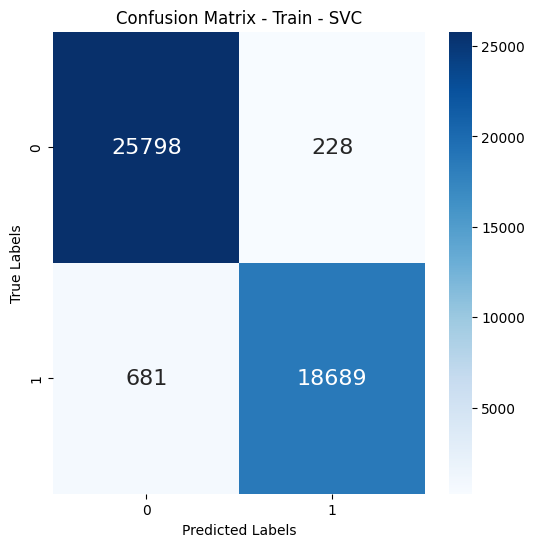

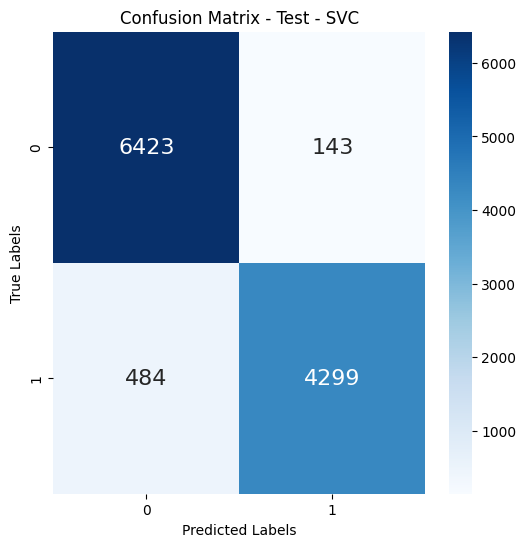

KNeighborsClassifier
*******Train************
Accuracy:  0.9220856463124505
Precision:  0.9664722173118849
Recall:  0.8467733608673206
F1 Score:  0.9026719132660079
*******Test************
Accuracy:  0.9005198695920346
Precision:  0.95675
Recall:  0.8001254442818315
F1 Score:  0.8714562222475237

 



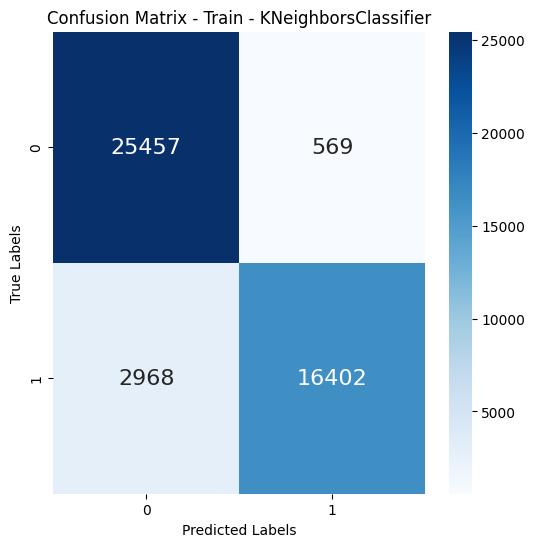

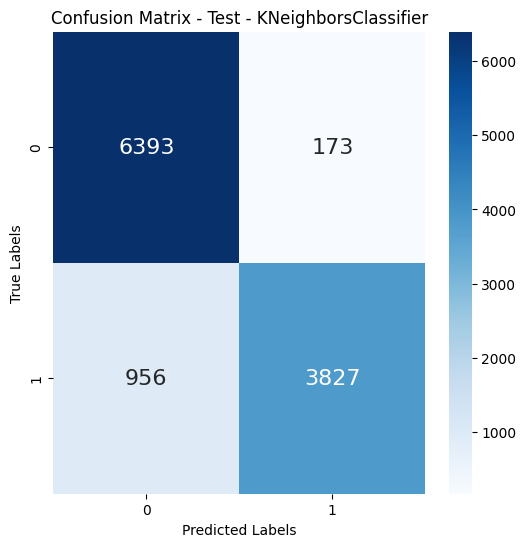

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression
*******Train************
Accuracy:  0.973059300378888
Precision:  0.9839974395903345
Recall:  0.9523489932885906
F1 Score:  0.9679145787968623
*******Test************
Accuracy:  0.9447528416600581
Precision:  0.9607538802660753
Recall:  0.9059167886263851
F1 Score:  0.9325298611858388

 



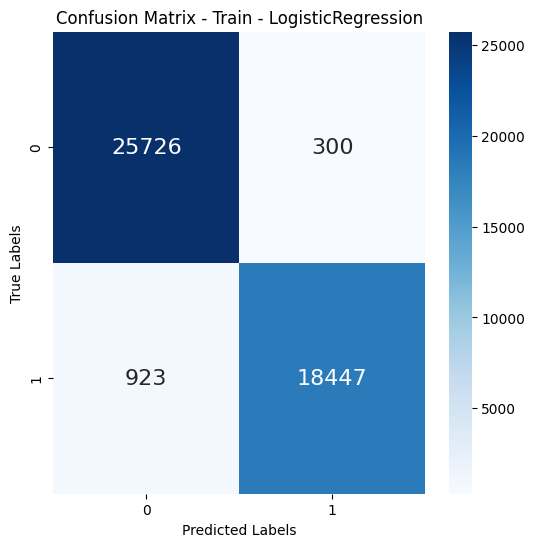

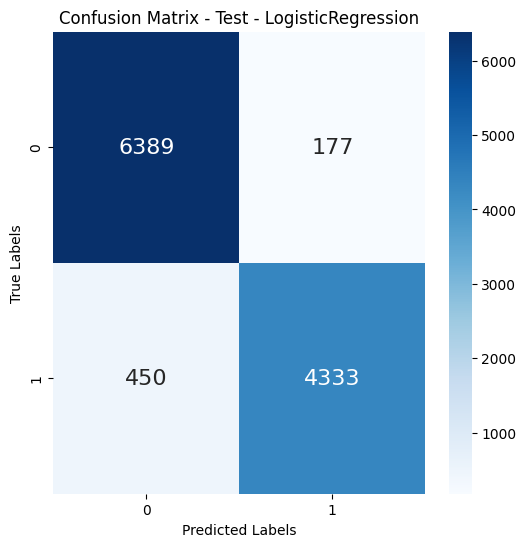

DecisionTreeClassifier
*******Train************
Accuracy:  0.9995374041765794
Precision:  0.9995868835528015
Recall:  0.9993288590604027
F1 Score:  0.9994578546534143
*******Test************
Accuracy:  0.9357652656621729
Precision:  0.9290855207451313
Recall:  0.9176249215973239
F1 Score:  0.9233196591984855

 



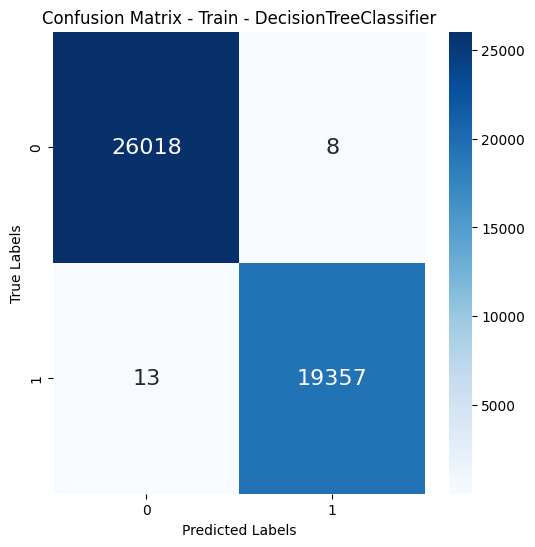

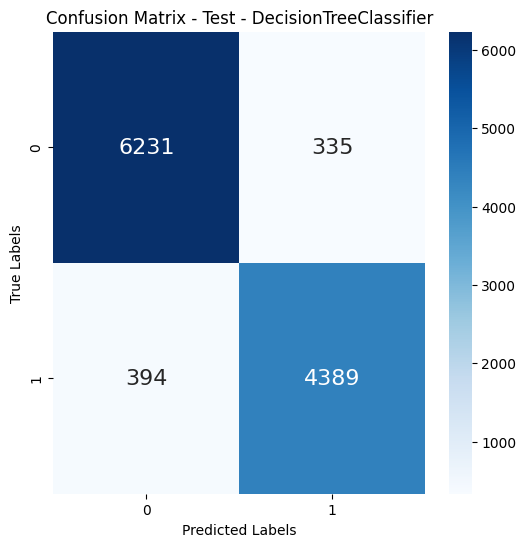

RandomForestClassifier
*******Train************
Accuracy:  0.9995153758040356
Precision:  0.9994836844279223
Recall:  0.9993804852865256
F1 Score:  0.9994320821931953
*******Test************
Accuracy:  0.9422856639351485
Precision:  0.9434894714224323
Recall:  0.9180430692034288
F1 Score:  0.9305923492635372

 



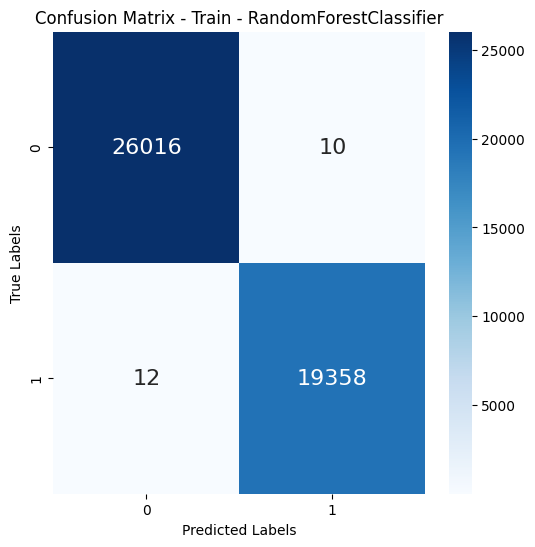

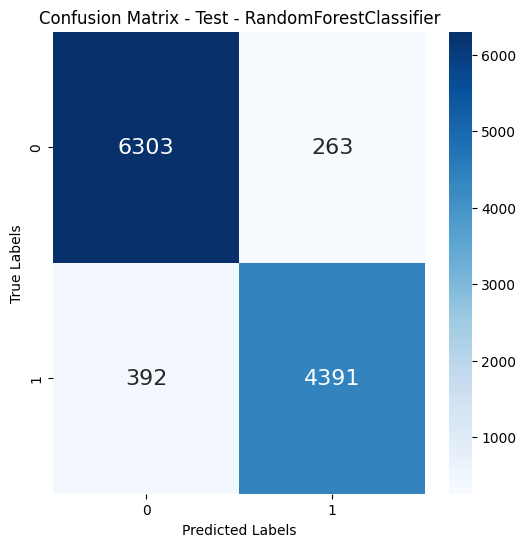

MultinomialNB
*******Train************
Accuracy:  0.9374834787205921
Precision:  0.9076740974551194
Recall:  0.9501290655653072
F1 Score:  0.928416485900217
*******Test************
Accuracy:  0.9190237025288571
Precision:  0.8801652892561983
Recall:  0.9351871210537319
F1 Score:  0.906842372022301

 



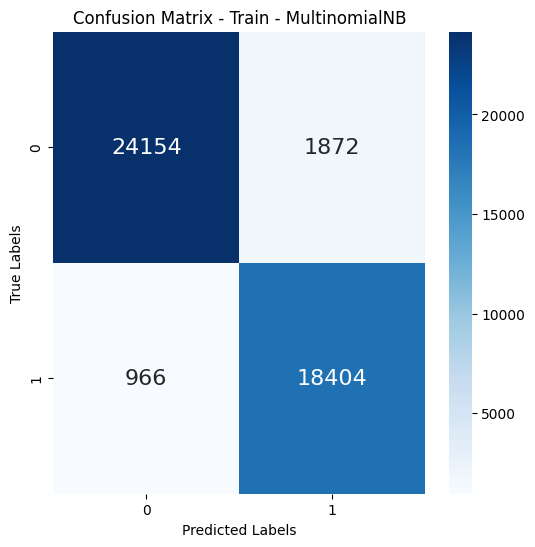

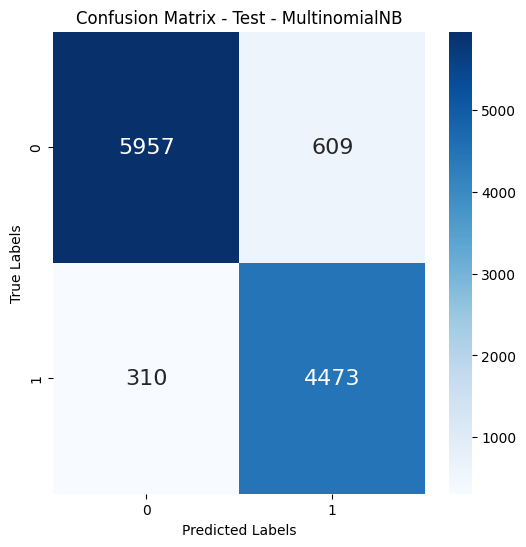

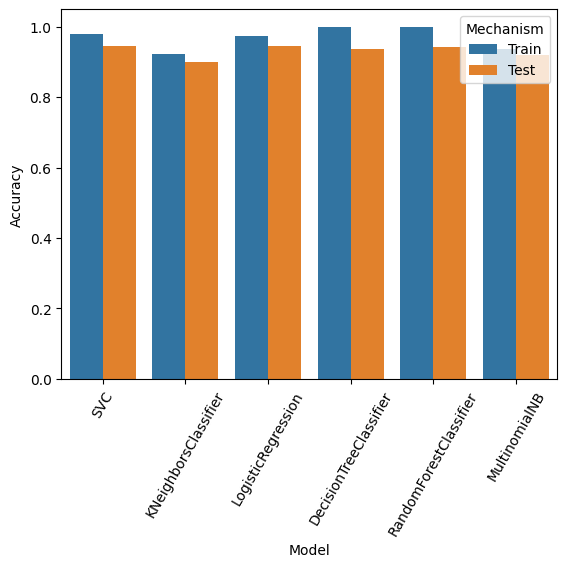

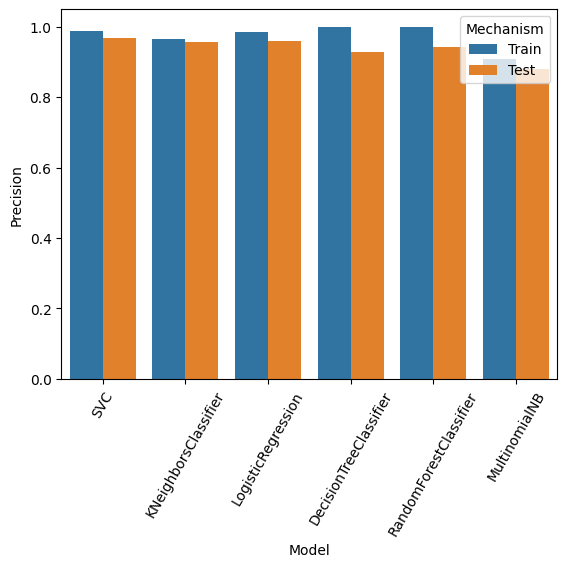

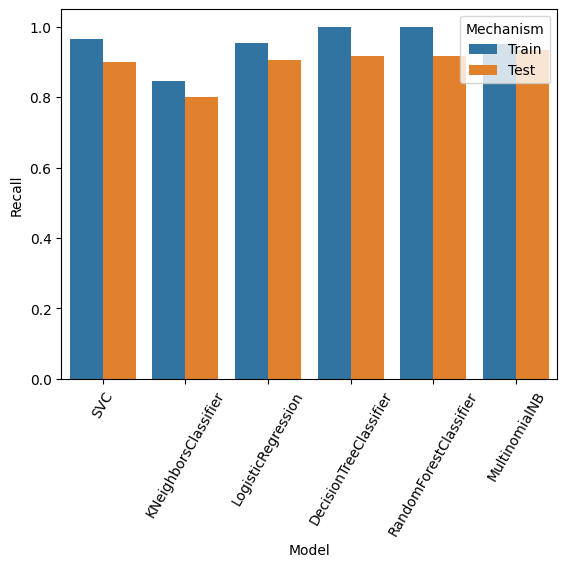

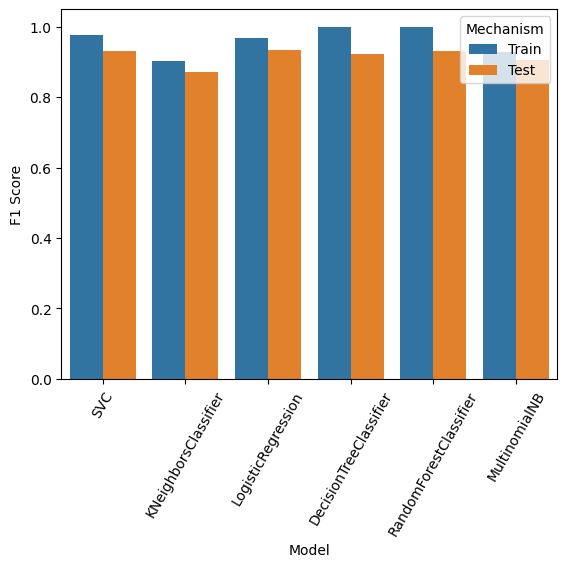

In [25]:
models = [SVC(),KNeighborsClassifier(),LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),MultinomialNB()]
train_accuracies = []
train_precisions = []
train_recalls = []
train_f1s = []
test_accuracies = []
test_precisions = []
test_recalls = []
test_f1s = []
model_names = []
for model in models:
    model.fit(x_train,y_train)
    train_pred = model.predict(x_train)
    #train_probs = model.predict_proba(x_train)[:, 1]
    test_pred = model.predict(x_test)
    #test_probs = model.predict_proba(x_test)[:, 1]
    print(type(model).__name__)
    model_names.append(type(model).__name__)
    print("*******Train************")
    print("Accuracy: ",accuracy_score(y_train,train_pred))
    print("Precision: ",precision_score(y_train,train_pred))
    print("Recall: ",recall_score(y_train,train_pred))
    print("F1 Score: ",f1_score(y_train,train_pred))
    train_accuracies.append(accuracy_score(y_train,train_pred))
    train_precisions.append(precision_score(y_train,train_pred))
    train_recalls.append(recall_score(y_train,train_pred))
    train_f1s.append(f1_score(y_train,train_pred))

    print("*******Test************")
    print("Accuracy: ",accuracy_score(y_test,test_pred))
    print("Precision: ",precision_score(y_test,test_pred))
    print("Recall: ",recall_score(y_test,test_pred))
    print("F1 Score: ",f1_score(y_test,test_pred))
    test_accuracies.append(accuracy_score(y_test,test_pred))
    test_precisions.append(precision_score(y_test,test_pred))
    test_recalls.append(recall_score(y_test,test_pred))
    test_f1s.append(f1_score(y_test,test_pred))
    print("\n \n")
    # Calculate and display the confusion matrix for training data
    plot_confusion_matrices(y_train, train_pred, f"Confusion Matrix - Train - {type(model).__name__}")

    # Calculate and display the confusion matrix for testing data
    plot_confusion_matrices(y_test, test_pred, f"Confusion Matrix - Test - {type(model).__name__}")

    # Calculate and display the ROC-AUC curve for training data
    '''plot_roc_auc_curve(y_train, train_probs, f"ROC-AUC Curve - Train - {type(model).__name__}")

    # Calculate and display the ROC-AUC curve for testing data
    plot_roc_auc_curve(y_test, test_probs, f"ROC-AUC Curve - Test - {type(model).__name__}")'''

train_df = pd.DataFrame()
train_df['Accuracy'] =  train_accuracies
train_df['Precision'] =  train_precisions
train_df['Recall'] =  train_recalls
train_df['F1 Score'] =  train_f1s
train_df['Mechanism'] = "Train"
train_df['Model'] = model_names

test_df = pd.DataFrame()
test_df['Accuracy'] =  test_accuracies
test_df['Precision'] =  test_precisions
test_df['Recall'] =  test_recalls
test_df['F1 Score'] =  test_f1s
test_df['Mechanism'] = "Test"
test_df['Model'] = model_names

result_df = pd.concat([train_df, test_df])
for metric in ['Accuracy','Precision','Recall','F1 Score']:
    sns.barplot(data =result_df,x ='Model',y = metric,hue="Mechanism")
    plt.xticks(rotation=60)
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


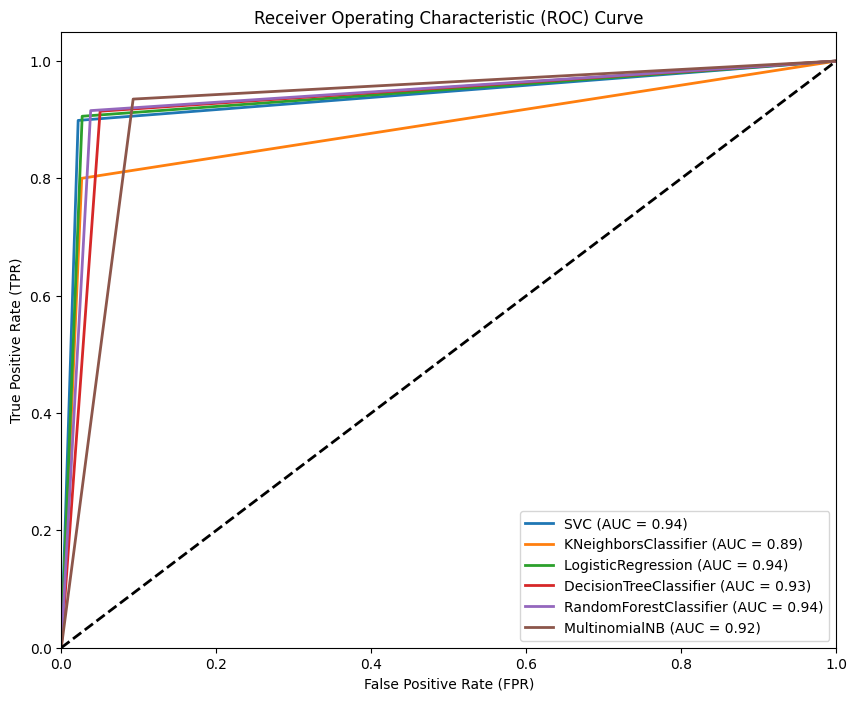

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

# Lists to store ROC curve data
fpr_list = []
tpr_list = []
roc_auc_list = []
model_names = []

models = [SVC(), KNeighborsClassifier(), LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), MultinomialNB()]

for model in models:
    model_name = type(model).__name__
    model_names.append(model_name)

    model.fit(x_train, y_train)
    y_pred_test = model.predict(x_test)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_test)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    # Calculate ROC-AUC score
    roc_auc = auc(fpr, tpr)
    roc_auc_list.append(roc_auc)

# Plot ROC-AUC curves for all models
plt.figure(figsize=(10, 8))
for i in range(len(models)):
    plt.plot(fpr_list[i], tpr_list[i], lw=2, label=f'{model_names[i]} (AUC = {roc_auc_list[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
